In [2]:
# config (run before anything else)
N_SPLITS = 5
RANDOM_SEED = 42

## Initial analysis


In [3]:
# load data from data/train.csv
import pandas as pd

data = pd.read_csv("data/train.csv", sep=";")

# print the first 3 rows
print(data.head(3))

   chef_id                     recipe_name        data  \
0     5060            chefy s rice pudding  29/01/2002   
1     3288  lasagna in the pressure cooker  14/12/2016   
2     5060                    ham frittata  22/09/2004   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['60-minutes-or-less', 'time-to-make', 'course...   

                                               steps  \
0  ['cook rice according to package directions', ...   
1  ['in the opened pressure cooker , add the oil ...   
2  ['heat oven to 400f', 'heat oil in a non stick...   

                                         description  \
0             by request, from georgian bay gourmet.   
1  i love how quickly i can put together a meal i...   
2  great for a quick meal with left over ham! lot...   

                                         ingredients  n_ingredients  
0  ['long grain rice',

chef_id
4470    806
5060    534
3288    451
8688    432
1533    404
6357    372
Name: count, dtype: int64


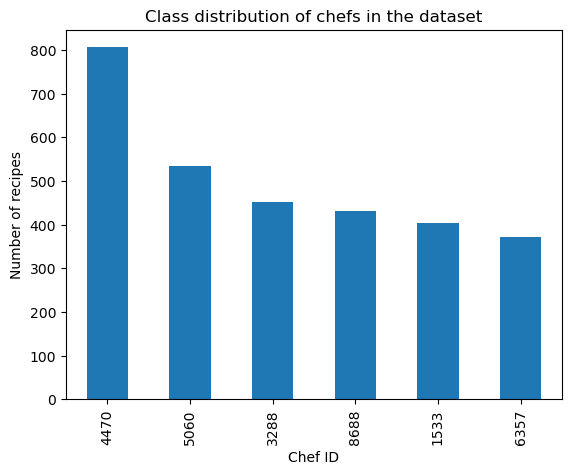

In [4]:
# column titles: chef_id, recipe_name, data, tags, steps, description, ingredients, n_ingredients

# checking the class distribution:
# how many recipes does each of the 6 chefs have?
# is the dataset unbalanced?

print(data["chef_id"].value_counts())

import matplotlib.pyplot as plt

data["chef_id"].value_counts().plot(kind="bar")
plt.xlabel("Chef ID")
plt.ylabel("Number of recipes")
plt.title("Class distribution of chefs in the dataset")
plt.show()

In [5]:
from collections import Counter
import re

unique_chefs = data["chef_id"].unique()

print("--- Chef Style and Vocabulary Analysis ---\n")

# list of common stop words to ignore in vocabulary analysis (TODO: this probably needs to be more specific to cooking)
import nltk

nltk.download("stopwords")
from nltk.corpus import stopwords

STOP_WORDS = set(stopwords.words("english"))

# --- 1. qualitative analysis: looking at examples ---
print("## Qualitative Analysis: Recipe Examples per Chef\n")

for chef_id in unique_chefs:
    print(f"--- Chef ID: {chef_id} ---")

    # filter the DataFrame to get recipes only for the current chef
    chef_data = data[data["chef_id"] == chef_id]

    # display the first 2 recipes for a quick look
    for index, recipe in chef_data.head(2).iterrows():
        print(f"\n  Recipe: {recipe['recipe_name']}")
        print(f"  Tags: {recipe['tags']}")
        print(f"  Description: {recipe['description']}")
        print("-" * 20)
    print("\n" + "=" * 50 + "\n")


# --- 2. quantitative analysis: vocabulary check ---
print("## Quantitative Analysis: Most Common Words in Descriptions\n")

common_words = Counter()
TOP_N = 25
chef_word_counts = {}  # store full counts per chef
chef_totals = {}  # store total words per chef
chef_topN_sets = {}
for chef_id in unique_chefs:
    print(f"--- Top 10 Most Common Words for Chef ID: {chef_id} ---")

    # isolate the descriptions for the current chef and combine them into one text block
    chef_descriptions = " ".join(
        data[data["chef_id"] == chef_id]["description"].dropna().astype(str)
    )

    # find all words, convert to lowercase for consistency
    words = re.findall(r"\b\w+\b", chef_descriptions.lower())

    # filter out the common stop words and numbers
    filtered_words = [
        word for word in words if word not in STOP_WORDS and not word.isdigit()
    ]

    # count the frequency of the remaining words
    word_counts = Counter(filtered_words)

    # print the 10 most common words and their counts
    print(word_counts.most_common(10))
    print("\n")

    chef_word_counts[chef_id] = word_counts
    chef_totals[chef_id] = sum(word_counts.values())

    top_words = [w for w, _ in word_counts.most_common(TOP_N)]
    chef_topN_sets[chef_id] = set(top_words)

    for w in top_words:
        common_words[w] += 1


# show words that appear in at least 2 chefs' top 10s, maybe remove most common?
print(f"\n=== Words common across chefs' top-{TOP_N} lists ===")
for word, n_chefs in common_words.most_common():
    if n_chefs > 1:
        print(f"\nWord: '{word}' → appears in {n_chefs} chefs top {TOP_N} list")
        for chef_id in unique_chefs:
            count = chef_word_counts[chef_id][word]
            total = chef_totals[chef_id]
            perc = 100 * count / total if total > 0 else 0
            marker = "  ⭐" if word in chef_topN_sets[chef_id] else ""
            print(f"  Chef {chef_id}: {count} times ({perc:.2f}%) {marker}")

--- Chef Style and Vocabulary Analysis ---

## Qualitative Analysis: Recipe Examples per Chef

--- Chef ID: 5060 ---

  Recipe: chefy s rice pudding
  Tags: ['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'for-large-groups', 'desserts', 'lunch', 'rice', 'canadian', 'oven', 'easy', 'potluck', 'dinner-party', 'fall', 'heirloom-historical', 'holiday-event', 'kid-friendly', 'winter', 'puddings-and-mousses', 'grains', 'dietary', 'low-sodium', 'seasonal', 'comfort-food', 'inexpensive', 'ontario', 'low-in-something', 'pasta-rice-and-grains', 'long-grain-rice', 'taste-mood', 'to-go', 'equipment', 'number-of-servings']
  Description: by request, from georgian bay gourmet.
--------------------

  Recipe: ham frittata
  Tags: ['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'very-low-carbs', 'omelets-and-frittatas', 'breakfast', 'eggs-dairy', 'cana

[nltk_data] Downloading package stopwords to /Users/vasco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
print("## Inspecting Data\n")
sample_row = data.iloc[0]

print(f"Type of 'tags' field: {type(sample_row['tags'])}")
print(f"Content: {sample_row['tags']}\n")

# 'tags', 'steps', and 'ingredients' are already lists of strings
# we can work with them directly
print("## Directly Accessing List Elements\n")
if sample_row["tags"]:
    print(f"The first tag is: '{sample_row['tags'][0]}'")
    print(f"The last ingredient is: '{sample_row['ingredients'][-1]}'\n")

## Inspecting Data

Type of 'tags' field: <class 'str'>
Content: ['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'for-large-groups', 'desserts', 'lunch', 'rice', 'canadian', 'oven', 'easy', 'potluck', 'dinner-party', 'fall', 'heirloom-historical', 'holiday-event', 'kid-friendly', 'winter', 'puddings-and-mousses', 'grains', 'dietary', 'low-sodium', 'seasonal', 'comfort-food', 'inexpensive', 'ontario', 'low-in-something', 'pasta-rice-and-grains', 'long-grain-rice', 'taste-mood', 'to-go', 'equipment', 'number-of-servings']

## Directly Accessing List Elements

The first tag is: '['
The last ingredient is: ']'



## Plan for preprocessing

**Main goal:** transform various text fields (`recipe_name`, `tags`, `steps`, `description`, `ingredients`) into a single, clean, and unified text input for each recipe. This consolidated text can then be converted into numerical vectors for a machine learning model.

### Step 1: extract humerical features
Before cleaning or combining text, we extract numerical descriptors that capture structural and stylistic aspects of each recipe.  
Each feature is stored in a separate column in the dataset.

**Extracted features:**

- **`description_length`** — total number of word tokens across name, description, steps, and ingredients.  
- **`mentions_time`** — binary flag if text mentions time (e.g., *min*, *hour*, *seconds*).  
- **`mentions_temp`** — binary flag if text mentions temperature (e.g., *°C*, *°F*, *degree*, *temperature*).  
- **`n_actions`** — count of cooking verbs such as *mix*, *bake*, *chop*, etc.  
- **`n_steps`** — number of steps in the recipe.  
- **`avg_step_length`** — average number of tokens per step.  
- **`tokens_per_step`** — ratio between total words and number of steps.  
- **`recipe_name_length`** — number of tokens in the recipe title.  
- **`n_ingredients`** — already present in the data.  
### Step 2: combine text fields

Combine all the text-based columns into a single "document" for each recipe. This creates a comprehensive representation of the recipe's content and style.

**Concatenate columns:** for each row (recipe), we'll merge the contents of the following columns:

- `recipe_name` (string)
- `description` (string)
- `steps` (list of strings)
- `ingredients` (list of strings)

**Handle lists:** since tags, steps, and ingredients are lists, we'll join their elements into a single space-separated string before combining them with the other fields.

### Step 3: clean and normalize the text

Apply standard text cleaning techniques to normalize the combined text. This ensures consistency and reduces the complexity of the vocabulary our model has to learn.

- **Convert to lowercase:** all text will be converted to lowercase; this is a crucial step to treat words like "Chicken", "chicken", and "CHICKEN" as the same word.
- **Remove punctuation and numbers:** we'll remove all punctuation (e.g., `.` `,` `!` `'`) and numbers; while numbers can be relevant in recipes (e.g., "30 minutes"), they can also create an enormous number of unique tokens; for an initial model, removing them simplifies the problem; we can always revisit this decision if model performance is lacking.

### Step 4: handle stop words carefully

Remove stop words (common words that add little descriptive value). We have to be strategic about this.

- **General stop words:** we'll start by removing a standard list of English stop words like 'the', 'a', 'is', 'in', 'at'. These words are frequent but don't help differentiate one chef's style from another.
- **Domain-specific stop words:** we should consider removing words that are extremely common in all recipes, as they are unlikely to be useful predictors; the preliminary analysis showed words like recipe, make, use, and dish are highly frequent across multiple chefs; these could be added to a custom stop word list; however, it's best to start by only removing the general stop words and then iteratively add domain-specific ones if the model's performance can be improved by forcing it to focus on more unique vocabulary.


In [7]:
import re
import numpy as np
import ast
# --- Step 1: extract numerical features ---

# ---------------------------
# Helper functions
# ---------------------------

def safe_list_parse(x):
    """Parse stringified lists like "['a','b']" or '["a", "b"]'."""
    s = "" if x is None else str(x).strip()
    if not s:
        return []
    try:
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple)):
            return [str(t).strip() for t in v if str(t).strip()]
    except Exception:
        pass
    s = s.strip("[]")
    parts = [p.strip().strip("'").strip('"') for p in s.split(",")]
    return [p for p in parts if p]

word_re = re.compile(r"[A-Za-z]+")

def tokenize_words(text):
    return word_re.findall("" if text is None else str(text))

def count_words(text):
    return len(tokenize_words(text))

def mentions_time(text):
    t = ("" if text is None else str(text)).lower()
    return int(bool(re.search(r"\b(min(ute)?s?|hr|hrs|hour|hours|sec|secs|second|seconds)\b", t)))

def mentions_temp(text):
    t = ("" if text is None else str(text)).lower()
    return int(bool(re.search(r"(\d+\s?°\s?[cf])|\b(degree|degrees|°c|°f|celsius|fahrenheit|temperature)\b", t)))

ACTIONS = {
    "mix","stir","bake","cook","heat","fry","chop","add","boil","grill",
    "combine","serve","pour","slice","beat","whisk","saute","preheat","season"
}

def count_actions(text):
    toks = [w.lower() for w in tokenize_words(text)]
    return sum(1 for w in toks if w in ACTIONS)


# ---------------------------
# Numerical feature extraction
# ---------------------------

steps_list = data["steps"].apply(safe_list_parse)
ing_list   = data["ingredients"].apply(safe_list_parse)

# Build raw text for counting
raw_text_for_counts = (
    data["recipe_name"].fillna("").astype(str) + " " +
    data["description"].fillna("").astype(str) + " " +
    steps_list.apply(lambda xs: " ".join(xs)) + " " +
    ing_list.apply(lambda xs: " ".join(xs))
)

# Core features
data["description_length"] = raw_text_for_counts.apply(count_words)
data["mentions_time"]      = raw_text_for_counts.apply(mentions_time)
data["mentions_temp"]      = raw_text_for_counts.apply(mentions_temp)
data["n_actions"]          = raw_text_for_counts.apply(count_actions)

# Step-based features
data["n_steps"] = steps_list.apply(len)
data["avg_step_length"] = steps_list.apply(
    lambda xs: float(np.mean([len(tokenize_words(s)) for s in xs])) if len(xs)>0 else 0.0
)
data["tokens_per_step"] = data.apply(
    lambda r: (r["description_length"]/r["n_steps"]) if r["n_steps"]>0 else 0.0, axis=1
)

# Title-based
data["recipe_name_length"] = data["recipe_name"].apply(count_words)

# Ensure no NaNs
numeric_features = [
    "n_ingredients",
    "description_length","n_steps","avg_step_length",
    "mentions_time","mentions_temp","n_actions","tokens_per_step",
    "recipe_name_length",
]
data[numeric_features] = data[numeric_features].fillna(0)

print("\n✅ Numerical features computed:")
print(data[numeric_features].head(3))



✅ Numerical features computed:
   n_ingredients  description_length  n_steps  avg_step_length  mentions_time  \
0              6                  72        8         6.375000              0   
1             13                 234       16        11.687500              1   
2             12                 190       13        11.692308              1   

   mentions_temp  n_actions  tokens_per_step  recipe_name_length  
0              0          6         9.000000                   4  
1              0         11        14.625000                   5  
2              0         10        14.615385                   2  


In [8]:
# --- Step 2: combine text fields ---

# all columns to be combined
text_columns = ["recipe_name", "description", "tags", "steps", "ingredients"]

# fill any potential missing values (NaN) with an empty string
for col in text_columns:
    data[col] = data[col].fillna("")

# columns that are string representations of lists
list_like_columns = ["tags", "steps", "ingredients"]

# remove list-like characters and commas
for col in list_like_columns:
    data[col] = (
        data[col]
        .str.strip("[]")
        .str.replace("'", "", regex=False)
        .str.replace('"', "", regex=False)
        .str.replace(",", "", regex=False)
    )

# concatenate columns, separated by spaces
data["document"] = data[text_columns].apply(lambda row: " ".join(row), axis=1)

# print first row of the original columns
print("Original columns (first row):")
print(
    data[
        ["recipe_name", "description", "tags", "steps", "ingredients", "document"]
    ].head(1)
)

# display resulting single 'document'
print("\nResulting 'document':")
print(data["document"].iloc[0])

Original columns (first row):
            recipe_name                             description  \
0  chefy s rice pudding  by request, from georgian bay gourmet.   

                                                tags  \
0  60-minutes-or-less time-to-make course main-in...   

                                               steps  \
0  cook rice according to package directions scal...   

                                         ingredients  \
0  long grain rice half-and-half cream eggs sugar...   

                                            document  
0  chefy s rice pudding by request, from georgian...  

Resulting 'document':
chefy s rice pudding by request, from georgian bay gourmet. 60-minutes-or-less time-to-make course main-ingredient cuisine preparation occasion north-american for-large-groups desserts lunch rice canadian oven easy potluck dinner-party fall heirloom-historical holiday-event kid-friendly winter puddings-and-mousses grains dietary low-sodium seasonal comfort-food

In [9]:
# --- Step 3: clean and normalize the text ---

# convert to lowercase
data["document_cleaned"] = data["document"].str.lower()

# remove punctuation and numbers using a raw string for the regex pattern
data["document_cleaned"] = data["document_cleaned"].str.replace(
    r"[^a-z\s]", "", regex=True
)

# remove extra whitespace using a raw string
data["document_cleaned"] = (
    data["document_cleaned"].str.replace(r"\s+", " ", regex=True).str.strip()
)

# sanity check
print("\nOriginal 'document' (first row):")
print(data["document"].iloc[0])

print("\nCleaned and normalized 'document' (first row):")
print(data["document_cleaned"].iloc[0])


Original 'document' (first row):
chefy s rice pudding by request, from georgian bay gourmet. 60-minutes-or-less time-to-make course main-ingredient cuisine preparation occasion north-american for-large-groups desserts lunch rice canadian oven easy potluck dinner-party fall heirloom-historical holiday-event kid-friendly winter puddings-and-mousses grains dietary low-sodium seasonal comfort-food inexpensive ontario low-in-something pasta-rice-and-grains long-grain-rice taste-mood to-go equipment number-of-servings cook rice according to package directions scald cream combine eggs  sugar  and vanilla place rice and raisins in oven proof casserole  add cream and egg mixture stir place casserole in a pan of hot water and baketil custard is partially set  remove from oven stir and set aside to cool long grain rice half-and-half cream eggs sugar vanilla raisins

Cleaned and normalized 'document' (first row):
chefy s rice pudding by request from georgian bay gourmet minutesorless timetomake c

In [10]:
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

# --- Step 4: handle stop words ---

# load standard set of English stop words
stop_words = set(stopwords.words("english"))

# remove stop words from the 'document_cleaned' column
# split each document into words and then rejoin only the words not in the stop_words set
data["document_no_stopwords"] = data["document_cleaned"].apply(
    lambda text: " ".join([word for word in text.split() if word not in stop_words])
)

# display the document after cleaning and after stop word removal to compare
print("\n'document_cleaned' (first row):")
print(data["document_cleaned"].iloc[0])

print("\n'document' after removing general stop words (first row):")
print(data["document_no_stopwords"].iloc[0])

backup_data = data

# we proceed without adding domain-specific stop words for now
# if model performance is poor, we can create a custom list like this and add it:
# custom_stop_words = {'recipe', 'make', 'use', 'dish'}
# all_stop_words = stop_words.union(custom_stop_words)
# and then rerun this cell using 'all_stop_words' instead of 'stop_words'


'document_cleaned' (first row):
chefy s rice pudding by request from georgian bay gourmet minutesorless timetomake course mainingredient cuisine preparation occasion northamerican forlargegroups desserts lunch rice canadian oven easy potluck dinnerparty fall heirloomhistorical holidayevent kidfriendly winter puddingsandmousses grains dietary lowsodium seasonal comfortfood inexpensive ontario lowinsomething pastariceandgrains longgrainrice tastemood togo equipment numberofservings cook rice according to package directions scald cream combine eggs sugar and vanilla place rice and raisins in oven proof casserole add cream and egg mixture stir place casserole in a pan of hot water and baketil custard is partially set remove from oven stir and set aside to cool long grain rice halfandhalf cream eggs sugar vanilla raisins

'document' after removing general stop words (first row):
chefy rice pudding request georgian bay gourmet minutesorless timetomake course mainingredient cuisine preparati

In [11]:
# select the relevant columns for model training
# 'document_no_stopwords' is the feature (X) and 'chef_id' is the target (y)
processed_data = data[["chef_id", "document_no_stopwords"]]

# display the first few rows of the saved data to confirm
print("\nFirst 5 rows of the pre-processed data:")
print(processed_data.head())


First 5 rows of the pre-processed data:
   chef_id                              document_no_stopwords
0     5060  chefy rice pudding request georgian bay gourme...
1     3288  lasagna pressure cooker love quickly put toget...
2     5060  ham frittata great quick meal left ham lots ta...
3     1533  red pepper garlic sauce nice salmon also tried...
4     5060  simple easy stuffed roast chicken gravy beginn...


# K-Fold Cross Validation

Instead of using a single 80%-20% train/validation split, we use Stratified K-Fold Cross Validation.

- The dataset is divided into K folds (e.g., N_SPLITS = 5).
- (Later) Each fold serves once as the validation set, while the remaining K-1 folds are combined to form the training set.
- This ensures that every sample is used for both training and validation, and the model performance is averaged across all folds.
- Stratification keeps the distribution of chef_id consistent in every fold.

We assign each row in the dataset to a fold (via a fold column), so we can train and evaluate models consistently across multiple folds.


In [12]:
from utils import create_folds

OUTPUT_PATH = "data/strong_baseline/folds_preprocessed.csv"

# create folds
create_folds(
    input_data=processed_data,
    output_file=OUTPUT_PATH,
    text_columns=["document_no_stopwords"],
    n_splits=N_SPLITS,
    random_seed=RANDOM_SEED,
)


## Chef ID Distribution Check

=== Original Dataset === (Size: 2999)
         Count  Percentage
chef_id                   
4470       806       26.88
5060       534       17.81
3288       451       15.04
8688       432       14.40
1533       404       13.47
6357       372       12.40

=== Fold 1 === (Size: 600)
         Count  Percentage
chef_id                   
4470       161       26.83
5060       107       17.83
3288        90       15.00
8688        86       14.33
1533        81       13.50
6357        75       12.50

=== Fold 2 === (Size: 600)
         Count  Percentage
chef_id                   
4470       162       27.00
5060       107       17.83
3288        90       15.00
8688        86       14.33
1533        81       13.50
6357        74       12.33

=== Fold 3 === (Size: 600)
         Count  Percentage
chef_id                   
4470       161       26.83
5060       107       17.83
3288        90       15.00
8688        87       14.50
1533        81       13.50
6357     

## Weak baseline

Doing everything again but for the weak baseline files.


In [13]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from utils import create_folds

# config
INPUT_FILE_PATH = "data/train.csv"
WEAK_FOLDS_OUTPUT_PATH = "data/weak_baseline/folds_preprocessed.csv"

# load raw data
print(f"Loading data from '{INPUT_FILE_PATH}'...")
data = pd.read_csv(INPUT_FILE_PATH, sep=";")

# preprocessing
# fill NaNs
data["description_processed"] = data["description"].fillna("")

# lowercase
data["description_processed"] = data["description_processed"].str.lower()

# remove punctuation and numbers (keep a-z and spaces)
data["description_processed"] = data["description_processed"].str.replace(
    r"[^a-z\s]", "", regex=True
)

# normalize whitespace
data["description_processed"] = (
    data["description_processed"].str.replace(r"\s+", " ", regex=True).str.strip()
)

# stopwords (English)
try:
    _ = stopwords.words("english")
except LookupError:
    nltk.download("stopwords")
stop_words_set = set(stopwords.words("english"))
data["description_processed"] = data["description_processed"].apply(
    lambda text: " ".join([w for w in text.split() if w not in stop_words_set])
)

create_folds(
    input_data=data[["chef_id", "description_processed"]],
    output_file=WEAK_FOLDS_OUTPUT_PATH,  # will save: chef_id | document | fold
    text_columns=["description_processed"],  # unified into 'document'
    n_splits=N_SPLITS,
    random_seed=RANDOM_SEED,
)

Loading data from 'data/train.csv'...

## Chef ID Distribution Check

=== Original Dataset === (Size: 2999)
         Count  Percentage
chef_id                   
4470       806       26.88
5060       534       17.81
3288       451       15.04
8688       432       14.40
1533       404       13.47
6357       372       12.40

=== Fold 1 === (Size: 600)
         Count  Percentage
chef_id                   
4470       161       26.83
5060       107       17.83
3288        90       15.00
8688        86       14.33
1533        81       13.50
6357        75       12.50

=== Fold 2 === (Size: 600)
         Count  Percentage
chef_id                   
4470       162       27.00
5060       107       17.83
3288        90       15.00
8688        86       14.33
1533        81       13.50
6357        74       12.33

=== Fold 3 === (Size: 600)
         Count  Percentage
chef_id                   
4470       161       26.83
5060       107       17.83
3288        90       15.00
8688        87       14.5

# Trying other stuff


## 1. Using all inputs

In this step, the dataset was prepared by combining text, numeric, and temporal information into a modeling-ready format:

1. **Date Parsing**  
   The `data` column, originally in string format (`dd/mm/YYYY`), was converted into a proper datetime type, allowing extraction of calendar features.

2. **Calendar Feature Extraction**  
   From the datetime, four features were extracted:

   - `year`
   - `month`
   - `day`
   - `day_of_week` (0 = Monday, 6 = Sunday)

3. **Cyclical Encoding**  
   To correctly represent periodic features (month and day of week), sine and cosine transformations were applied.

   - `month_sin` / `month_cos` map months onto a unit circle (December is close to January).
   - `dow_sin` / `dow_cos` do the same for days of the week (Sunday is close to Monday).

4. **Clean-Up**  
   The raw and intermediate columns (`data`, `year`, `month`, `day`, `day_of_week`) were dropped, leaving a compact dataset with:
   - Text features (`document_no_stopwords`)
   - Numeric features (`n_ingredients`, cyclical encodings)
   - Categorical features (`tags`)
   - Target (`chef_id`)


In [14]:
import pandas as pd
import numpy as np

# config
OUTPUT_PATH = "data/experiments/all_inputs.csv"

selected_cols = ["chef_id", "document_no_stopwords", "data", "n_ingredients",
    "description_length","n_steps","avg_step_length",
    "mentions_time","mentions_temp","n_actions","tokens_per_step",
    "recipe_name_length"]

new_df = backup_data[selected_cols].copy()
print(backup_data.columns.tolist())
print(new_df.columns.tolist())
print(new_df.head())

new_df["data"] = pd.to_datetime(new_df["data"], format="%d/%m/%Y", errors="coerce")

# extract features
new_df["year"] = new_df["data"].dt.year
new_df["month"] = new_df["data"].dt.month
new_df["day"] = new_df["data"].dt.day
new_df["day_of_week"] = new_df["data"].dt.dayofweek  # Monday=0, Sunday=6

# cyclic encoding for month and day_of_week
new_df["month_sin"] = np.sin(2 * np.pi * new_df["month"] / 12)
new_df["month_cos"] = np.cos(2 * np.pi * new_df["month"] / 12)

new_df["dow_sin"] = np.sin(2 * np.pi * new_df["day_of_week"] / 7)
new_df["dow_cos"] = np.cos(2 * np.pi * new_df["day_of_week"] / 7)
new_df = new_df.drop(columns=["data", "year", "month", "day", "day_of_week"])

print(new_df.head())

create_folds(
    input_data=new_df,
    output_file=OUTPUT_PATH,
    text_columns=["document_no_stopwords"],
    n_splits=N_SPLITS,
    random_seed=RANDOM_SEED,
)

['chef_id', 'recipe_name', 'data', 'tags', 'steps', 'description', 'ingredients', 'n_ingredients', 'description_length', 'mentions_time', 'mentions_temp', 'n_actions', 'n_steps', 'avg_step_length', 'tokens_per_step', 'recipe_name_length', 'document', 'document_cleaned', 'document_no_stopwords']
['chef_id', 'document_no_stopwords', 'data', 'n_ingredients', 'description_length', 'n_steps', 'avg_step_length', 'mentions_time', 'mentions_temp', 'n_actions', 'tokens_per_step', 'recipe_name_length']
   chef_id                              document_no_stopwords        data  \
0     5060  chefy rice pudding request georgian bay gourme...  29/01/2002   
1     3288  lasagna pressure cooker love quickly put toget...  14/12/2016   
2     5060  ham frittata great quick meal left ham lots ta...  22/09/2004   
3     1533  red pepper garlic sauce nice salmon also tried...  12/04/2005   
4     5060  simple easy stuffed roast chicken gravy beginn...  14/10/2004   

   n_ingredients  description_length  n

## 2. Remove custom words

Remove common words that appear among the top 25 most frequently used by each chef (as we've seen before).


In [15]:
import pandas as pd

# config
INPUT_PATH = "data/experiments/all_inputs.csv"
OUTPUT_PATH = "data/experiments/custom_words_removed.csv"

data = pd.read_csv(INPUT_PATH)
data = data.drop(columns=["document_no_stopwords"])

words_to_remove = ["great", "make", "recipe", "dish", "one"]

def remove_words(text):
    if isinstance(text, str):
        return " ".join(
            word for word in text.split() if word.lower() not in words_to_remove
        )
    return text


data["document"] = data["document"].apply(remove_words)

data.to_csv(OUTPUT_PATH, index=False)
print(f"Saved dataset to {OUTPUT_PATH}")

Saved dataset to data/experiments/custom_words_removed.csv


## 3. Lemmatization

In [16]:
import pandas as pd
import nltk, re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# download resources once (only needed the first time)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("omw-1.4")

# config
INPUT_PATH = "data/experiments/all_inputs.csv"
OUTPUT_PATH = "data/experiments/lemmatization.csv"

lemmatizer = WordNetLemmatizer()


def lemmatize_text(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text.lower())
    processed = [
        lemmatizer.lemmatize(tok) for tok in tokens if re.match(r"[a-z]+", tok)
    ]
    return " ".join(processed)


data = pd.read_csv(INPUT_PATH)
data = data.drop(columns=["document_no_stopwords"])

data["document"] = data["document"].apply(lemmatize_text)

data.to_csv(OUTPUT_PATH, index=False)
print(f"Saved lemmatized dataset to {OUTPUT_PATH}")

original_doc = pd.read_csv(INPUT_PATH)["document"].head()
for before, after in zip(original_doc, data["document"].head()):
    print("BEFORE:", before)
    print("AFTER: ", after)
    print("-" * 80)

[nltk_data] Downloading package punkt to /Users/vasco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/vasco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vasco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/vasco/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Saved lemmatized dataset to data/experiments/lemmatization.csv
BEFORE: chefy rice pudding request georgian bay gourmet minutesorless timetomake course mainingredient cuisine preparation occasion northamerican forlargegroups desserts lunch rice canadian oven easy potluck dinnerparty fall heirloomhistorical holidayevent kidfriendly winter puddingsandmousses grains dietary lowsodium seasonal comfortfood inexpensive ontario lowinsomething pastariceandgrains longgrainrice tastemood togo equipment numberofservings cook rice according package directions scald cream combine eggs sugar vanilla place rice raisins oven proof casserole add cream egg mixture stir place casserole pan hot water baketil custard partially set remove oven stir set aside cool long grain rice halfandhalf cream eggs sugar vanilla raisins
AFTER:  chefy rice pudding request georgian bay gourmet minutesorless timetomake course mainingredient cuisine preparation occasion northamerican forlargegroups dessert lunch rice canadian

## 4. Stemming

In [17]:
import pandas as pd
import nltk, re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# download resources once (only needed the first time)
nltk.download("punkt")
nltk.download("punkt_tab")

# config
INPUT_PATH = "data/experiments/all_inputs.csv"
OUTPUT_PATH = "data/experiments/stemming.csv"

stemmer = PorterStemmer()


def stem_text(text):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text.lower())
    processed = [stemmer.stem(tok) for tok in tokens if re.match(r"[a-z]+", tok)]
    return " ".join(processed)


# load data
data = pd.read_csv(INPUT_PATH)
data = data.drop(columns=["document_no_stopwords"])

# apply stemming
data["document"] = data["document"].apply(stem_text)

# save
data.to_csv(OUTPUT_PATH, index=False)
print(f"Saved stemmed dataset to {OUTPUT_PATH}")

# quick preview difference
original_doc = pd.read_csv(INPUT_PATH)["document"].head()
for before, after in zip(original_doc, data["document"].head()):
    print("BEFORE:", before)
    print("AFTER: ", after)
    print("-" * 80)

[nltk_data] Downloading package punkt to /Users/vasco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/vasco/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Saved stemmed dataset to data/experiments/stemming.csv
BEFORE: chefy rice pudding request georgian bay gourmet minutesorless timetomake course mainingredient cuisine preparation occasion northamerican forlargegroups desserts lunch rice canadian oven easy potluck dinnerparty fall heirloomhistorical holidayevent kidfriendly winter puddingsandmousses grains dietary lowsodium seasonal comfortfood inexpensive ontario lowinsomething pastariceandgrains longgrainrice tastemood togo equipment numberofservings cook rice according package directions scald cream combine eggs sugar vanilla place rice raisins oven proof casserole add cream egg mixture stir place casserole pan hot water baketil custard partially set remove oven stir set aside cool long grain rice halfandhalf cream eggs sugar vanilla raisins
AFTER:  chefi rice pud request georgian bay gourmet minutesorless timetomak cours mainingredi cuisin prepar occas northamerican forlargegroup dessert lunch rice canadian oven easi potluck dinnerpa

## 5. Sub-words

(also 1 option with sub-words + lemmatization)


In [18]:
import pandas as pd

# config
INPUT_PATH = "data/experiments/all_inputs.csv"

OUTPUT_TXT = "data/experiments/sub_words/document.txt"  # ChatGPT 5 will do subwording on this file

# load data
data = pd.read_csv(INPUT_PATH)
data = data.drop(columns=["document_no_stopwords"])

print(data.columns.to_list())

with open(OUTPUT_TXT, "w", encoding="utf-8") as f:
    for doc in data["document"].astype(str):
        f.write(doc.strip().replace("\n", " ") + "\n")

print(f"Wrote {len(data)} data to {OUTPUT_TXT}")

['chef_id', 'n_ingredients', 'description_length', 'n_steps', 'avg_step_length', 'mentions_time', 'mentions_temp', 'n_actions', 'tokens_per_step', 'recipe_name_length', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'document', 'fold']
Wrote 2999 data to data/experiments/sub_words/document.txt


In [19]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer

# config
INPUT_PATH = "data/experiments/all_inputs.csv"
INPUT_TXT = "data/experiments/sub_words/sub_words.txt"  # sub-words given by ChatGPT
OUTPUT_SUBWORDS = "data/experiments/sub_words/sub_words.csv"
OUTPUT_LEMMA = "data/experiments/sub_words/lemmatized_sub_words.csv"

# load original dataframe
df = pd.read_csv(INPUT_PATH)
df = df.drop(columns=["document_no_stopwords", "document"], errors="ignore")

# read subworded text (1 line per document, same order)
with open(INPUT_TXT, "r", encoding="utf-8") as f:
    subword_lines = [line.strip().replace("</w>", "") for line in f]

# sanity check
assert len(subword_lines) == len(df), "Mismatch between documents and subworded lines!"

# add new column
df["document"] = subword_lines

# save updated dataframe
df.to_csv(OUTPUT_SUBWORDS, index=False)
print(df.columns.tolist())

print(f"Saved dataframe with subworded documents to {OUTPUT_SUBWORDS}")

# lemmatization of subwords
lemmatizer = WordNetLemmatizer()

def lemmatize_line(line: str) -> str:
    tokens = line.split()
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return " ".join(lemmas)

df["document"] = df["document"].astype(str).apply(lemmatize_line)

# save lemmatized version
df.to_csv(OUTPUT_LEMMA, index=False)
print(f"Saved dataframe with lemmatized subworded documents to {OUTPUT_LEMMA}")

['chef_id', 'n_ingredients', 'description_length', 'n_steps', 'avg_step_length', 'mentions_time', 'mentions_temp', 'n_actions', 'tokens_per_step', 'recipe_name_length', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'fold', 'document']
Saved dataframe with subworded documents to data/experiments/sub_words/sub_words.csv
Saved dataframe with lemmatized subworded documents to data/experiments/sub_words/lemmatized_sub_words.csv
